<a href="https://colab.research.google.com/github/t-willi/Simula/blob/main/AE_V2_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
import matplotlib.pyplot as plt
import torchvision
from torchvision import datasets, models, transforms
from torchvision.transforms import ToTensor
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from timeit import default_timer as timer 
import glob
import torch.optim as optim
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler



if torch.cuda.is_available()==True:
  device="cuda:0"
else:
  device ="cpu"

In [ ]:
k = [1,2,3,4]
k=np.array(k)
t = ToTensor()

In [ ]:
def normalize_df_per_column(df):
  for i,k in enumerate(df.columns):
    max=df.iloc[:,i].max()
    min=df.iloc[:,i].min()
    df.iloc[:,i] = df.iloc[:,i].apply(lambda x: ((x-min)/(max-min)))
  return df


In [ ]:
def normalize_list(l):
  max=max(l)
  min=min(l)
  l=l.apply(lambda x:((x-min)/(max-min)))
  return l



In [ ]:
# from pathlib import Path
# data_dir="/content/train_CSV_data"
# train_data_dir_normal="/content/train_CSV_data_normal"
# files = glob.glob(data_dir + '/*.csv')
# for f in files:
#   temp_df = pd.read_csv(f,sep=" ")
#   normal_df = normalize_df_per_column(temp_df)
#   if train_data_dir_normal.is_dir():
#     print(f"{train_data_dir_normal} directory exists.")
#   else:
#     print(f"Did not find {train_data_dir_normal} directory, creating one...")
#     train_data_dir_normal.mkdir(parents=True, exist_ok=True)





In [ ]:
# import requests
# import zipfile
# from pathlib import Path
# #load data to directory from github
# # Setup path to data folder
# data_path = Path("data/")
# train_path = data_path / "small_train"
# #test_path = data_path / "train_CSV_data"

# if train_path.is_dir():
#     print(f"{train_path} directory exists.")
# else:
#     print(f"Did not find {train_path} directory, creating one...")
#     train_path.mkdir(parents=True, exist_ok=True)
    
#     # Download train data
#     with open(data_path / "small_train.zip", "wb") as f:
#         request = requests.get("https://github.com/t-willi/Simula/blob/main/small_train.zip")
#         print("Downloading train data")
#         f.write(request.content)

#    # Unzip pizza, steak, sushi data
#     with zipfile.ZipFile(data_path / "small_train.zip", "r") as zip_ref:
#         print("Unzipping ") 
#         zip_ref.extractall(train_path)


In [ ]:
# Create custom dataset class to load ECG data into dataset, containing 
# input tensor with lead 1 and output tensor with desired other leads
class Custom_dataset(Dataset):
    def __init__(self, data_dir,normalize=False):
      #get all files from directory loaded in all_files list
      self.all_files = []
      self.files = glob.glob(data_dir + '/*.csv')
      for f in self.files:
        temp_df = pd.read_csv(f,sep=" ")
        self.all_files.append(temp_df)
        # self.normalize=Normalize
        self.transform=ToTensor()

    def __len__(self):
      return len(self.all_files)

    def __getitem__(self,idx):
      Data = []
      #turn list of dataframes into Tensor
      for f in self.files:
        #load_dataframe
        temp_df=pd.read_csv(f,sep=" ")
        #load input tensor
        temp_list_in=temp_df.iloc[:,1]
        temp_list_in=normalize([temp_list_in], norm="max")
        temp_tensor_in = torch.tensor(temp_list_in,dtype=torch.float32)
        temp_tensor_in=temp_tensor_in.unsqueeze(0)
        #load label Tensor
        temp_list_out=temp_df.iloc[:,3].values
        temp_list_out=normalize([temp_list_out], norm="max")
        temp_tensor_out=torch.tensor(temp_list_out,dtype=torch.float32)
        temp_tensor_out=temp_tensor_out.unsqueeze(0)
        #combine input and label and output
        temp_tensor_pair= temp_tensor_in,temp_tensor_out
      return temp_tensor_pair

In [ ]:
train_dataset = Custom_dataset(data_dir="/content/train_CSV_data",normalize=True)
test_dataset = Custom_dataset(data_dir="/content/test_CSV_data",normalize=True)



In [ ]:
# x,y=train_dataset[0]
# y.shape

In [ ]:
from torch.utils.data.dataloader import DataLoader
BATCH_SIZE = 10
#turn datasets into iterables
train_dataloader = DataLoader(train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )
test_dataloader = DataLoader(test_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True
                              )

In [ ]:
"""
Here, we define the autoencoder model.This model is taken from "https://github.com/L1aoXingyu/pytorch-beginner/blob/master/08-AutoEncoder/simple_autoencoder.py"
"""
class ECG_AE_v1(nn.Module):
    def __init__(self):
        super(ECG_AE_v1, self).__init__()
        self.AE = nn.Sequential(
            nn.Linear(4999, 128),
            nn.ReLU(),
            nn.Linear(128,20),
            nn.ReLU(),
            nn.Linear(20,10),
            nn.ReLU(),
            nn.Linear(10,20),
            nn.ReLU(),
            nn.Linear(20,128),
            nn.ReLU(),
            nn.Linear(128,4999),
        )


    def forward(self, x):
        x = self.AE(x)
        return x


model = ECG_AE_v1().to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)



In [ ]:
model

ECG_AE_v1(
  (AE): Sequential(
    (0): Linear(in_features=4999, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): ReLU()
    (6): Linear(in_features=10, out_features=20, bias=True)
    (7): ReLU()
    (8): Linear(in_features=20, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=4999, bias=True)
  )
)

In [ ]:
try: 
    import torchinfo
except:
    !pip install torchinfo
    import torchinfo

from torchinfo import summary
summary(model, input_size=[1,4999]) # do a test pass through of an example input size 

Layer (type:depth-idx)                   Output Shape              Param #
ECG_AE_v1                                [1, 4999]                 --
├─Sequential: 1-1                        [1, 4999]                 --
│    └─Linear: 2-1                       [1, 128]                  640,000
│    └─ReLU: 2-2                         [1, 128]                  --
│    └─Linear: 2-3                       [1, 20]                   2,580
│    └─ReLU: 2-4                         [1, 20]                   --
│    └─Linear: 2-5                       [1, 10]                   210
│    └─ReLU: 2-6                         [1, 10]                   --
│    └─Linear: 2-7                       [1, 20]                   220
│    └─ReLU: 2-8                         [1, 20]                   --
│    └─Linear: 2-9                       [1, 128]                  2,688
│    └─ReLU: 2-10                        [1, 128]                  --
│    └─Linear: 2-11                      [1, 4999]                 644,8

In [ ]:
t1= torch.rand(1,20)
t1.shape
t1=torch.reshape(t1,(4,5))
t1.shape

torch.Size([4, 5])

In [ ]:
from tqdm.auto import tqdm
torch.manual_seed(42)
#train and test loop
Epochs = 5
for epoch in tqdm(range(Epochs)):
  print(f"Epoch:{epoch}")
  train_loss=0
  for batch, (X,y) in enumerate(train_dataloader): 
    X, y = X.to(device), y.to(device) 
    model.train()
    output=model(X)
    ##reshaping output from linear to 2d from 40000 to 8 times 5000
    #output=torch.reshape(output,(1,1,8,4999))
    ######
    loss = criterion(output,y)
    train_loss += loss
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  #average loss per batch
  train_loss /= len(train_dataloader)
  #start testing
  test_loss = 0
  model.eval()
  with torch.inference_mode():
    for X,y in test_dataloader:
      X, y = X.to(device), y.to(device) 
      test_pred = model(X)
      ##reshaping output from linear to 2d from 40000 to 8 times 5000
      #test_pred=torch.reshape(test_pred,(10,1,8,4999))
      ######
      test_loss += criterion(test_pred,y)    
    test_loss /= len(test_dataloader)

  #print what is happening
  print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}")
    




  0%|          | 0/5 [00:00<?, ?it/s]

Epoch:0


KeyboardInterrupt: ignored

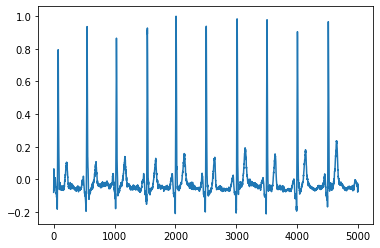

In [ ]:
input,output = train_dataset[0]
input
input=input.tolist()
data=input[0][0]
type(data)
plt.plot(data)
# plt.title("Input ECG lead1")

Text(0.5, 1.0, 'Output ECG trained for 20epochs on 50 datapoints')

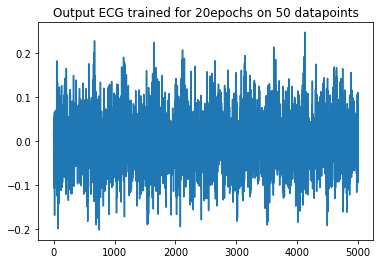

In [ ]:
X,y=test_dataset[0]
model.to("cpu")
model.eval()
with torch.inference_mode():
  output=model(X)
output=output.tolist()
data=output[0][0]
plt.plot(data)
plt.title("Output ECG trained for 20epochs on 50 datapoints")

In [ ]:
X,y=test_dataset[0]
model.to("cpu")
model.eval()
with torch.inference_mode():
  output=model(X)
output

tensor([[[ 0.0200, -0.0374,  0.0261,  ...,  0.1108, -0.0934, -0.0196]]])